In [17]:
import argparse
import subprocess
import os
import json
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import sleep
import concurrent.futures
from matplotlib.patches import Patch

def load_data(input_dir):

    def stats_type_from_file_name(file_name):
        return file_name.split("_")[-1].split(".")[0]
    records = []
    for f in os.listdir(input_dir):
        if f.endswith(".json"):
            with open(os.path.join(input_dir, f)) as json_f:
                records.extend(json.load(json_f)[2:])
    df = pd.DataFrame(records)
    df['time_per_column'] = df['metadata_end_to_end_load_time_nanos'] / df['column_cnt']
    df['stats'] = df.apply(lambda x: stats_type_from_file_name(x['file_name']), axis=1)
    return df

In [23]:
input_dir =  "../target/wide_table_bench/"

df_baseline = load_data(input_dir + "old") 
df_mimalloc = load_data(input_dir + "mimalloc")
df_mimalloc_no_stats = load_data(input_dir + "mimalloc_no_stats")
df_mimalloc_no_stats_simd = load_data(input_dir + "mimalloc_no_stats_simd")
# df_simd = load_data(input_dir + "simd")

df_baseline['variant'] = 'Baseline'
df_mimalloc['variant'] = '+mimalloc'
df_mimalloc_no_stats['variant'] = '+layout opt'
df_mimalloc_no_stats_simd['variant'] = '+simd'
# df_simd['variant'] = 'SIMD' 
df = pd.concat([df_baseline,df_mimalloc, df_mimalloc_no_stats, df_mimalloc_no_stats_simd])

df = df[df['column_cnt'] == 100_000]

df['size_per_column'] = df['metadata_len'] / df['column_cnt']
df['bytes_per_ms'] = df['metadata_len'] / (df['metadata_end_to_end_load_time_nanos'] / 1_000_000)

def stats_order(x):
	if x['stats'] == 'none':
		return 1
	if x['stats'] == 'chunk':
		return 2
	if x['stats'] == 'page':
		return 3
df['order'] = df.apply(stats_order, axis=1)
df.sort_values(by='order', inplace=True)

In [24]:
time_per_column = df.groupby('stats')[['time_per_column', 'stats']].describe()['time_per_column']
time_per_column.sort_values(by='mean', ascending=True, inplace=True)

size_per_column = df.groupby('stats')[['size_per_column', 'stats']].describe()['size_per_column']
size_per_column.sort_values(by='mean', ascending=True, inplace=True)

In [29]:
(250000.0 - 142857)/142857

0.75000175000175

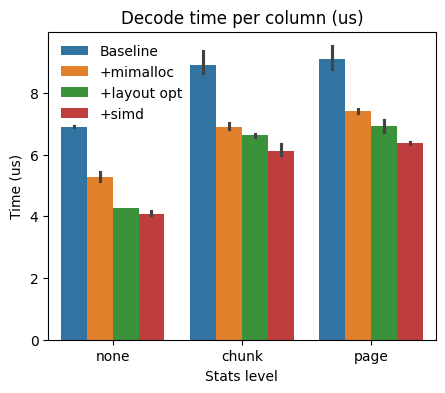

In [26]:
# hue_order = ['Baseline', 'mimalloc' ]

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
sns.barplot(x='stats', y='time_per_column', data=df, hue='variant',  ax=ax1)
ax1.set_xlabel('Stats level')
ax1.set_ylabel('Time (us)')
ax1.set_title('Decode time per column (us)')
ax1.legend(title='', frameon=False)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}'.format(x/1e3)))

fig.savefig('mimalloc.png', dpi=300)


In [12]:

decode_time = {
	'file_metadata_decode': 587,
	'row_group_metadata_decode': 300,
	'Parquet to Arrow Schema': 38 + 5+16+12,
}


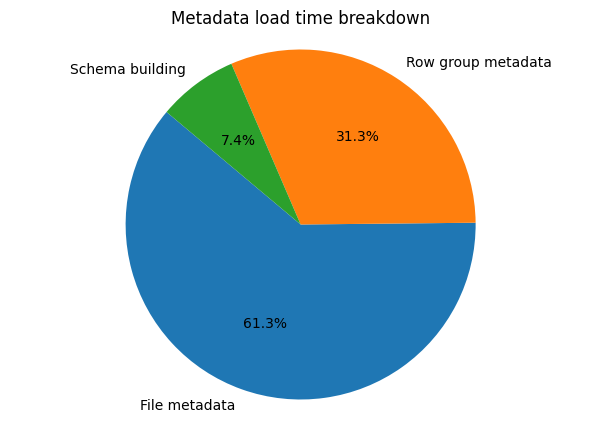

In [16]:
labels_updated = [
    'File metadata',
    'Row group metadata',
    'Schema building'
]


# Create lists of keys and values
labels = list(decode_time.keys())
values = list(decode_time.values())

fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 5))
ax1.pie(values, labels=labels_updated, autopct='%1.1f%%', startangle=140)
ax1.set_title('Metadata load time breakdown')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()
fig.savefig('time-decomposition.png', dpi=300)